# Adquisción de variables climatológicas mediante API GEE

Elflujo de trabajo desarrollado es:
    
    - Delimitación de variables
    - Conectar GEE
    - Delimitar temporalmente los datos
    - Adquirir datos

In [23]:
# Librerías a implementar
import ee
import geemap
import folium
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import optimize
#from google.colab import drive
%matplotlib inline 

In [2]:
#iniciar conexión con GEE
#ee.Authenticate()


Enter verification code:  4/1AZEOvhXUfBdIju-kcXQqDf7yNx_fbOB2ZW-Gkq5sCBJ1ZJZlTk_kwznWvF4



Successfully saved authorization token.


In [25]:
# Iniciarlizar
ee.Initialize()

## Establecimiento de área de trabajo

Aquí se carga el shapefile de la cuenca *La Baja* para usarlo coo área que limite las colecciones que se importen de *GEE* y puedan ser usadas como datos para la exploración y cruce de insumos

In [26]:
# Funciones para carga de geometrías desde shaefile a ee.Geometry
def load_geometry(ruta):
    polygon = ruta
    return geemap.shp_to_ee(polygon)
# Función para obtener centroide de una geometría
def make_centorid_map(polygon):
    poly_gometry = polygon.geometry()
    centroid = poly_gometry.centroid(1)
    return list(reversed(centroid.getInfo()['coordinates']))
# Cargar geometrías a usar en GEE
aoi = load_geometry('SHP/Guajira_Extend.shp') 
ventanas = load_geometry('SHP/Centroides_gcs.shp')
# Generar centroide a partir de polígono
centro_mapa = make_centorid_map(aoi)

## Evaluación de la precipitación multianual en zona de trabajo

Basado en los datos de [CHIRPS Daily](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY) se busca identificar cuál ha sido el comportameinto aproximado de la precipitación entre los años 2015 hasta diciemre 2022. Los datos hacen parte de la colección de información diaria corregida con estciones en terreno.

In [36]:
## Importar colección CHIRPS Daily y filtrar por fecha y área
valor = 'GWS_tavg'
# Definir fechas
fecha_inicio, fecha_fin = '2003-01-01','2023-05-31'
image_data = ee.ImageCollection('NASA/GLDAS/V022/CLSM/G025/DA1D')\
.filterDate(fecha_inicio, fecha_fin).select(valor)
# Cortar colección de datos a zona específica
def cortar_colecion(imagen):
    return imagen.clip(aoi)

image_data = image_data.map(cortar_colecion)
# almacenar nombre de la banda

## Resumir datos de diarios a mensuales
Los registros obtenidos hacen parte de una serie temporal diaria de CHIRPS, estos datos requieren ser comunicados en una escala mensual, para ello se crea un dataframe con la infomración media por mes entre las fechas determinadas

In [28]:
# Ver los primeros cinco registros del dataframe
def muestras_sobre_raster(image, puntos, escala):
    features = puntos.getInfo()
    muestras = [image.getRegion(feature['geometry'], escala).getInfo() for feature in features['features']]
    print(f'Se han recolectado {len(muestras[0])} datos de la banda {valor} para {len(muestras)} puntos de muestra.')
    return muestras


In [37]:
# Implementar función para adquirir datos
data_points = muestras_sobre_raster(image_data,ventanas,10)

Se han recolectado 7425 datos de la banda GWS_tavg para 31 puntos de muestra.


In [38]:
ident, longitude, latitude, time, valores, banda = [],[],[],[],[],[]

for punto in range(0,len(data_points)):
    for point in data_points[punto][1::]: # Evita  que los datos salten de 1 a 5
        if point == ['id', 'longitude', 'latitude', 'time', 'valores']:
            continue
        else:
            ident.append(point[0])
            longitude.append(point[1])
            latitude.append(point[2])
            # Convertir fecha de milisegundo epoca a %Y-%m-%d, 
            time.append(datetime.datetime.utcfromtimestamp(point[3]/1000).strftime('%Y-%m-%d'))
            valores.append(point[4])
            banda.append(valor)
            

In [39]:
df = pd.DataFrame({'ID': ident, 
                   'Long': longitude,
                  'Lat':latitude,
                  'Time':time,
                  valor:valores,
                  'Band':banda})
# resumir comportamiento de variable
df.iloc[:,3:5].describe()

GWS_tavg
count  230144.000000
mean      947.071013
std       393.198030
min       315.933441
25%       568.042374
50%       930.483978
75%      1230.211334
max      1868.220825

<Axes: >

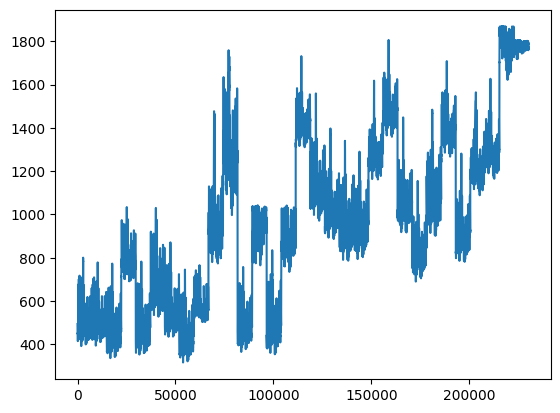

In [40]:
df[valor].plot()

In [41]:
# Guardar datos en csv
df.to_csv(f'Data/SerieDeTiempo_{valor}.csv')